In [2]:
!pip install -U openmim
!mim install mmcv-full
!pip install mmdet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 3.9 MB/s eta 0:00:00
  Attempting uninstall: openmim
    Found existing installation: openmim 0.2.0
    Uninstalling openmim-0.2.0:
      Successfully uninstalled openmim-0.2.0
--- Logging error ---
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/utils/logging.py", line 177, in emit
    self.console.print(renderable, overflow="ignore", crop=False, style=style)
  File "/usr/local/lib/python3.7/dist-packages/pip/_vendor/rich/console.py", line 1673, in print
    extend(render(renderable, render_options))
  File "/usr/local/lib/python3.7/dist-packages/pip/_vendor/rich/console.py", line 1305, in render
    for render_output in iter_render:
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/utils/logging.py", line 134, in __rich_console__
    for line in lines:
  File "/usr/local/lib/python3.7/dist-packages/pip/_vendor/rich/segment.py", line 249, in split_lines
    for segment

Get 'mim' extra requirements from `mminstall.txt` for mmdet 2.25.0: ['mmcv-full>=1.3.17'].
--- Logging error ---
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/utils/logging.py", line 177, in emit
    self.console.print(renderable, overflow="ignore", crop=False, style=style)
  File "/usr/local/lib/python3.7/dist-packages/pip/_vendor/rich/console.py", line 1673, in print
    extend(render(renderable, render_options))
  File "/usr/local/lib/python3.7/dist-packages/pip/_vendor/rich/console.py", line 1305, in render
    for render_output in iter_render:
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/utils/logging.py", line 134, in __rich_console__
    for line in lines:
  File "/usr/local/lib/python3.7/dist-packages/pip/_vendor/rich/segment.py", line 249, in split_lines
    for segment in segments:
  File "/usr/local/lib/python3.7/dist-packages/pip/_vendor/rich/console.py", line 1283, in render
    renderable = rich_cast(render

In [1]:
import numpy as np
from pycocotools.coco import COCO
from pycocotools import mask
import open3d as o3d
from pathlib import Path
import json
import math
import glob
from detector2d.common_utils.mask_utils import mask2polygon, segm2json, xyxy2xywh
from mmdet.apis import init_detector, inference_detector, show_result_pyplot
import mmcv
import datasets.shared_utils as shared_utils
from surface_completion.models.PartialSC import PartialSC
from easydict import EasyDict
import matplotlib.pyplot as plt
from datasets.shared_utils import draw_lidar_on_image, convert_to_o3dpcd

class Demo:
    # Single frame SEEv2 data augmentation
    def __init__(self, root_dir, camera, config_file, checkpoint_file, gpu_id):
        # Set configs here
        self.root_dir = Path(root_dir)
        self.camera = camera
        
        self.calib = self.load_calibration()     
        self.det2d_model = init_detector(config_file, checkpoint_file, device=f'cuda:{gpu_id}')
    
    def get_image_pcd_paths(self):
        img_paths = sorted(glob.glob(str(self.root_dir / 'image' / self.camera / '*')))
        pcd_paths = sorted(glob.glob(str(self.root_dir / 'pcd' / '*.pcd')))
        return list(zip(img_paths, pcd_paths))
        
    def load_calibration(self):
        calib_file = self.root_dir / 'calib'/ f'{self.camera}.json'
        assert calib_file.exists(), f'No calib file found at {calib_file}'
        with open(calib_file) as f:
            print(f'Loading calib from {calib_file}')
            return json.load(f) 
    
    def get_camera_instances(self, img, score_thresh=0.3):
        """
        Load mmdetection instance segmentor to get mask
        """
        result = inference_detector(self.det2d_model, img)
        segm_json_result = segm2json(result, [2], score_thresh=score_thresh, mask=True)
        
        coco_output = {}
        coco_output['images'] = [{'id': 0, 'height': img.shape[0], 'width': img.shape[1]}]
        coco_output['annotations'] = []
        instance_id = 0
        for segm in segm_json_result:
            instance_id = instance_id + 1
            annotation_info = {
                "id": instance_id,
                "image_id": 0,
                "category_id": segm["category_id"],
                "iscrowd": 0,
                "bbox": segm['bbox']
            }
            annotation_info['segmentation'] = mask2polygon(segm['segmentation'])
            coco_output['annotations'].append(annotation_info)
            
        with open('demo.json', 'w+') as f:
            json.dump(coco_output, f)
            
        cocomask = COCO('demo.json')
        ann_ids = cocomask.getAnnIds(imgIds=0, catIds=[2]) # car is cat_id=2
        instances = cocomask.loadAnns(ann_ids)
        self.coco = cocomask
        return instances
    
    def get_pointcloud(self, lidar_file):        
        assert Path(lidar_file).exists(), f'No lidar file found at {lidar_file}'
        pcd = o3d.io.read_point_cloud(str(lidar_file))
        return np.asarray(pcd.points)
    
    def get_image(self, img_path):
        assert Path(img_path).exists(), f'No image file found at {img_path}'
        return mmcv.imread(img_path, channel_order='rgb')
    
    def map_pointcloud_to_image(self, image, points, min_dist=1.0):
        """
        Filter lidar points, keep those in image FOV
        """
        IMG_H, IMG_W, _ = image.shape
        cameramat = np.array(self.calib['intrinsic']).reshape((3,3))
        lidar2cam = np.array(self.calib['extrinsic']).reshape((4,4))

        pts_3d_hom = np.hstack((points, np.ones((points.shape[0],1)))).T # (4,N)
        pts_imgframe = (lidar2cam[:3,:] @ pts_3d_hom).T # (3,4) * (4,N) = (3,N)        
    
        tmpxC = pts_imgframe[:,0] / pts_imgframe[:,2]
        tmpyC = pts_imgframe[:,1] / pts_imgframe[:,2]
        r2 = tmpxC ** 2 + tmpyC ** 2
        r1 = np.sqrt(r2)
        a0 = np.arctan(r1)
        
#         distcoeff = [-0.097824, 0.141429, -0.148385, 0.055918]
        distcoeff = [0,0,0,0]
        a1 = a0*(1 + distcoeff[0] * (a0**2) + distcoeff[1]* (a0**4) + distcoeff[2]* (a0**6) + distcoeff[3]* (a0**8))

        u =(a1/r1)*tmpxC
        v =(a1/r1)*tmpyC
        u = (cameramat[0,0]*u + cameramat[0,2])[...,np.newaxis]
        v = (cameramat[1,1]*v + cameramat[1,2])[...,np.newaxis]
        uv = np.hstack([u,v, pts_imgframe[:,2][...,np.newaxis]])
        
        fov_inds =  (uv[:,0] > 0) & (uv[:,0] < IMG_W -1) & \
            (uv[:,1] > 0) & (uv[:,1] < IMG_H -1)

        imgfov = {"pc_lidar": points[fov_inds,:],
                  "pc_cam": uv[fov_inds,:], # same as pts_img, just here to keep it consistent across datasets
                  "pts_img": np.round(uv[fov_inds,:],0).astype(int),
                  "fov_inds": fov_inds }
        return imgfov
    
    def isolate(self, pts, eps_scaling=5, vres=1.0, min_lidar_pts=30):
        raw_pcds = convert_to_o3dpcd(pts)
        ring_heights = [np.linalg.norm(pcd.get_center()) * np.tan(vres * np.pi/180) for pcd in raw_pcds]
        eps = [eps_scaling * ring_height for ring_height in ring_heights]
        out_pcd = [shared_utils.db_scan(raw_pcds[i], eps=eps[i], return_largest_cluster=True) for i in range(len(raw_pcds)) if len(raw_pcds[i].points)>5]
        pcds = [np.asarray(pcd.points) for pcd in out_pcd if len(pcd.points) > min_lidar_pts]
        return pcds
    
    def replace_with_completed_pts(self, points, sc_instances, point_distance_thresh=0.2):
        # Remove the original points of the car
        original_pcd = convert_to_o3dpcd(points)
        dist = original_pcd.compute_point_cloud_distance(convert_to_o3dpcd(sc_instances))
        cropped_inds = np.where(np.asarray(dist) < 0.2)[0]
        pcd_without_object = np.asarray(original_pcd.select_by_index(cropped_inds, invert=True).points)

        # Replace with complete points
        pcd_with_all_complete = np.vstack((sc_instances, pcd_without_object))
        return pcd_with_all_complete

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


INFO - 2022-08-23 14:04:34,529 - driver - Generating grammar tables from /usr/lib/python3.7/lib2to3/Grammar.txt
INFO - 2022-08-23 14:04:34,557 - driver - Generating grammar tables from /usr/lib/python3.7/lib2to3/PatternGrammar.txt


In [18]:
from pathlib import Path

# /mnt/big-data/darren/data/nuscenes/v1.0-trainval/samples/MESHED_LIDAR_TOP_1SWEEPS_NUS-DM-ORH005/f286cdaef36648cba3b6a24d2178dc8a#000005.pcd
pth = '/SEEv2/data/nuscenes/v1.0-trainval/samples/MESHED_LIDAR_TOP_1SWEEPS_NUS-DM-ORH005/f286cdaef36648cba3b6a24d2178dc8a#000005.pcd'
print(Path(pth).exists())

pcd = o3d.io.read_point_cloud(pth)
o3d.visualization.draw_geometries([pcd])

True


In [77]:
# Edit dataset configs here
gpu_id = 1
demo_dataset = Demo(root_dir='/SEEv2/see/ouster', # /SEEv2/data/ouster
                    camera='front',
                    config_file = '/SEEv2/see/detector2d/mmdetection/configs/htc/htc_x101_64x4d_fpn_dconv_c3-c5_mstrain_400_1400_16x1_20e_coco.py',
                    checkpoint_file = '/SEEv2/model_zoo/htc_x101_64x4d_fpn_dconv_c3-c5_mstrain_400_1400_16x1_20e_coco_20200312-946fd751.pth',
                    gpu_id=gpu_id)

partialsc = PartialSC(cfg=EasyDict({'MODEL': "PartialSC_VC", 
                                     'NORM_WITH_GT': False,
                                     'SEL_K_NEAREST': 30,
                                     'CLUSTER_EPS': 0.3,
                                     'BATCH_SIZE_LIMIT': 32,
                                     'CKPT_PATH': "/SEEv2/model_zoo/PartialSC_VC.pth"}), 
                      gpu_id=gpu_id)

Loading calib from /SEEv2/see/ouster/calib/front.json
load checkpoint from local path: /SEEv2/model_zoo/htc_x101_64x4d_fpn_dconv_c3-c5_mstrain_400_1400_16x1_20e_coco_20200312-946fd751.pth
PartialSC_VC initialised, batch_size_limit: 32


## Check calibration

In [64]:
# Load
img_path, pcd_path = demo_dataset.get_image_pcd_paths()[0]
img = demo_dataset.get_image(img_path)
points = demo_dataset.get_pointcloud(pcd_path)

# Filter x > 0, and -y_lim < y < +y_lim to easier see the pointcloud in image
points = points[points[:,0] > 0]
y_lim = 20
points = points[(points[:,1] > -y_lim) & (points[:,1] < y_lim)]
imgfov = demo_dataset.map_pointcloud_to_image(img, points)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


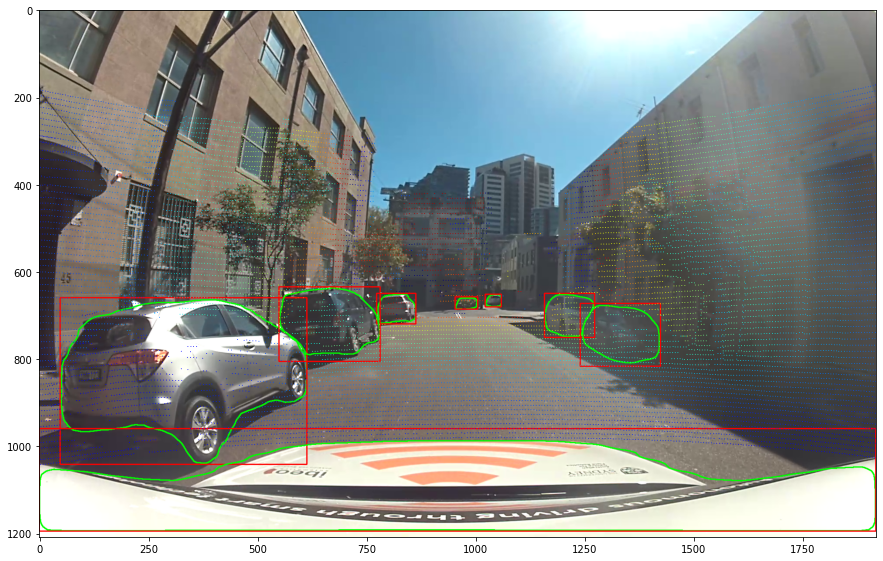

In [85]:
instances = demo_dataset.get_camera_instances(img, score_thresh=0.5)
_ = draw_lidar_on_image(imgfov['pts_img'], 
                                 img, 
                                 instances, 
                                 point_size=1,
                                 map_range=25.0,
                                 instance_mask=True)

## Full pipeline of image+mask to augmented pcd

In [83]:
# Load
img_path, pcd_path = demo_dataset.get_image_pcd_paths()[0]
img = demo_dataset.get_image(img_path)
points = demo_dataset.get_pointcloud(pcd_path)
points = points[points[:,0] > 0] # filter points behind camera

imgfov = demo_dataset.map_pointcloud_to_image(img, points)

# Get instances
instances = demo_dataset.get_camera_instances(img, score_thresh=0.5)
instance_pts = shared_utils.get_pts_in_mask(demo_dataset.coco, 
                                instances, 
                                imgfov,
                                shrink_percentage=3,
                                use_bbox=False)
iso_pts = demo_dataset.isolate(instance_pts['lidar_xyz'], eps_scaling=5, vres=0.6)

# Complete surfaces
sc_model_ret = partialsc.inference(iso_pts,
                                batch_size_limit=partialsc.batch_size_limit,                                         
                                k=partialsc.surface_sel_k)
sc_model_ret['all_instances'] = np.unique(np.vstack(sc_model_ret['clustered']), axis=0)

# Augment pointcloud
sc_instances = sc_model_ret['all_instances']
final_pcd = demo_dataset.replace_with_completed_pts(points, sc_instances)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [86]:
# Visualize
original_pcd = convert_to_o3dpcd(points)
original_pcd.paint_uniform_color([0.8,0.8,0.8])

pcd2 = convert_to_o3dpcd(sc_instances)

# Remove the original points of the cars
dist = original_pcd.compute_point_cloud_distance(pcd2)
cropped_inds = np.where(np.asarray(dist) < 0.1)[0]
pcd_without_object = original_pcd.select_by_index(cropped_inds, invert=True)

o3d.visualization.draw_geometries([pcd2, pcd_without_object])

In [30]:
instance_pts.keys()

dict_keys(['img_uv', 'cam_xyz', 'lidar_xyz', 'img_labels'])